# **K-Nearest Neighbors Explained**

## **Introduction**

K-Nearest Neighbors (K-NN) is a very simple algorithm and likely among the first encountered by people studying machine learning. You simply find the *k* nearest data points and use their labels to predict the labels of new data points. Here, *k* is some positive integer less than or equal to the number of data points. The optimal *k* is typically chosen through cross-validation. Lower values of *k* gives a more flexible model, while higher values of *k* give a less flexible model. The optimal value of *k* depends on how flexible the data generating process is and how much data you have.

K-NN is a non-parametric model. It makes no assumption about the model underlying the data generation process. It does not learn any parameters, as opposed to a linear model like ordinary least squares regression or logistic regression which learn coefficients in a linear model form. This gives it some advantages and disadvantages over more structured models.

### **Strengths**

* Makes no assumption about the data generating process so it can fit flexible models.

* "Training" the model is as fast as saving the data because it does not need to estimate parameters.

* It is simple to explain and implement.

### **Weaknesses**

* Makes no assumption about the data generating process, which can lead to overfitting without sufficient training observations or too small a **k** value.

* The data set must be stored where the model can access it, which can use up a large amount of memory with large data sets.

* Making predictions is relatively slow compared to parametric models because it needs to compute the distances to the training data points, sort them, retrieve the *k* closest points, and then make a prediction. 

* K-NN is a victim of the curse of dimensionality; it does not perform well with high dimensions where data points become very spread out.

* Works best when observations are close together in the feature space.

* K-NN is sensitive to outliers.

Some of the above strengths and weaknesses are two sides of the same coin, such as its flexibility and speed of "training" but high use of memory and slow predictive speed. With that being said, this is usually among the first two algorithms I try on prediction problems that look like they may be very non-linear when I have sufficient data points. If there are many dimensions, I generally use a dimensionality reduction technique, like principal components analysis, to get a lower dimensional space prior to modeling. 

Summarizing the strengths and weaknesses into a decision process for using K-NN, it is a good choice for non-linear functions with many observations and a poor choice when there is not much data and the data generating function doesn't require much flexibility.

## **The K-NN Algorithm**

The K-NN algorithm is very simple and the first five steps are the same for both classification and regression.

1. **Select **k** and the Weighting Method*

Choose a value of *k*, which is the number of nearest neighbors to retrieve for making predictions. The two choices of weighting method are **uniform** and **inverse distance weighting**. With **uniform weighting**, you do not take into account the distance from the new data point from its *k* nearest neighbors. They all have equal influence over the prediction. With **inverse distance weighting**, you assign high value to the closer training examples.

You will generally end up trying various values of *k* and weighting methods in cross-validation and go with the *k* and weighting method with the lowest cross-validation loss.

2. **"Train" the K-NN Model**

As mentioned above, there are no parameters to estimate in this model. You simply save the training data for making predictions.

3. **Pass Data for Prediction**

Simply pass your model a new data point to predict.

4. **Calculating the Distance**

Up until this point, I have said "nearest" without defining what I meant by that. There are multiple distance metrics and I will not cover them all. The one I will cover is the most common; Euclidean distance. Euclidean distance is simply the length of the line segment connecting two points. The formula for Euclidean distance between two points is below:

### $\text{Euclidean Distance}(\text{x}^{*}, \text{x}) = \sqrt{\Sigma^{m}_{i}(\text{x}^{*}_{i} - \text{x}_{i})^{2}}$

where $\text{x}^{*}$ is the feature vector of the new data point, $\text{x}$ is the feature vector of a single training data point, and $m$ is the number of features used for prediction. 

You calculate the distance, using your chosen metric, of the new data point from each of the training data points and temporarily save the distances for the next step.

5. **Finding the K-Nearest Neighbors**

Once you know the distances of each training observation from your new data point, you sort the data points by their distance from the new data point. You then select the *k* data points with the smallest distances. I used **quicksort** for sorting the distances in my implementation.

You now have found the *k* nearest neighbors in the training data to your new data point and can use their labels for prediction.

6. **Prediction**

Here is where the steps of the algorithm diverge for classification and regression.

**Regression**

For regression, you average the labels of the *k* nearest training data points and use that for the prediction of the newest data point. If using **uniform weighting**, this is the simple average of the labels. If using **inverse distance weighting**, you calculate the weighted average of the training labels, weighting the $i^{th}$ nearest neighbor's label by $\frac{1}{\text{distance}_{i}}$. This gives closer points more influence over the predicted label. If the distance is 0, the weight will be undefined because you cannot divide by 0. To get around this in my implementation, I give the option of adding a small value to the distance. This still results in a point with 0 distance having a very large weight on the predicted label.

**Classification**

For classification, you use the majority vote (for binary classification) or plurality vote (for multi-class) of the training labels to predict the new label. To avoid 50-50 vote splits, it is good to use an odd number for *k*. The proportion of votes for a class can be interpreted as the probability of the new data point belonging to that class. Like in the regression case, you can weight the votes of each of the *k* nearest neighbors by the inverse of their distance to give closer points more influence. 

## **Demonstration**

Now that we've covered how the algorithm works, I've simulated some data for a multi-class prediction problem and two regression problems to demonstrate how K-NN performs for simple problems with various values of *k* and weighting methods. Let's start with classification.

### **Classification Demonstration**

To demonstrate K-NN for classification, I simulated 100 data points from 3 classes each. Each class is parameterized by its own bivariate normal distribution. The means of each class are different with the same covariance matrix. This is the ideal case for Linear Discriminant Analysis, but we are just using that knowledge to plot the boundary of the Bayes Classifier.

First, we need to import the numpy, the multivariate_normal class from scipy's stats module, and the pyplot module from matplotlib.

$\text{Class 1} \sim \text{MVN}(\begin{bmatrix} 5.5 & 3 \end{bmatrix}, \begin{bmatrix} 2 & 0 \\ 0 & 3 \end{bmatrix}), \text{Class 2} \sim \text{MVN}(\begin{bmatrix} -0.5 & 4 \end{bmatrix}, \begin{bmatrix} 2 & 0 \\ 0 & 3 \end{bmatrix}), \text{Class 3} \sim \text{MVN}(\begin{bmatrix} 3 & -2 \end{bmatrix}, \begin{bmatrix} 2 & 0 \\ 0 & 3 \end{bmatrix})$

In [1]:
import os

path = os.sys.path[0].replace("\\test", "")
os.chdir(path)

import numpy as np
from KNearestNeighbors import KNNClassifier, KNNRegresser
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

Now that we have the useful modules and classes imported, it is time to simulate the data. I also created dictionaries to map labels to classes for plotting purposes.

In [2]:
# Set a random seed for reproducibility.
np.random.seed(1)

# Create lists for the mean of each distribution and the shared covariance terms.
mu_1 = [5.5, 3]
mu_2 = [-0.5, 4]
mu_3 = [3, -2]
sigmas = [2, 3]
# Create the instances of the data generating process of each class.
class_1 = multivariate_normal(mean=mu_1, cov=sigmas)
class_2 = multivariate_normal(mean=mu_2, cov=sigmas)
class_3 = multivariate_normal(mean=mu_3, cov=sigmas)

def max_prob(x):
    """This function returns the class based on the Bayes Classifier."""
    return np.argmax([class_1.pdf(x), class_2.pdf(x), class_3.pdf(x)], axis=0) + 1

# Set the number of data points in each class.
size = 100
# Sample from each of the classes.
X_1 = class_1.rvs(size)         
X_2 = class_2.rvs(size)
X_3 = class_3.rvs(size)

# Combine them into a single numpy array.
X = np.append(X_1, X_2, axis=0)
X = np.append(X, X_3, axis=0)
# Forget them to free memory.
del X_1
del X_2 
del X_3

# Create labels for each of the 3 classes.
y_1 = np.repeat(1, repeats=size)
y_2 = np.repeat(2, repeats=size)
y_3 = np.repeat(3, repeats=size)
# Append them all into 1 array.
y = np.append(y_1, y_2)
y = np.append(y, y_3)
# Forget them to free memory.
del y_1
del y_2 
del y_3

# Create arrays with 50 equidistant points along each dimension of the feature
# space.
detail = 75
x_1 = np.linspace(np.min(np.transpose(X)[0]), np.max(np.transpose(X)[0]), detail)
x_2 = np.linspace(np.min(np.transpose(X)[1]), np.max(np.transpose(X)[1]), detail)

# Create pairs of values covering the feature space and append them to a list.
feature_space = []
for i in x_1:
    for j in x_2:
        feature_space.append((i, j))
# Convert the list to a numpy array.       
feature_space = np.array(feature_space)

# Create a dictionary to map point labels to colors.
point_color_dict = {1: "blue",
                    2: "red",
                    3: "green"}
# Create a dictionary to map decision space labels to colors.
background_color_dict = {1: "lightblue",
                         2: "mistyrose",
                         3: "lightgreen"}

# Map classes to colors for the scatter plot.
point_colors = [point_color_dict[y_i] for y_i in y]

true_boundary = [background_color_dict[x] for x in max_prob(feature_space)]

Below is a scatter plot of the 100 draws from each of the 3 classes, with the decision boundary of the Bayes Classifier plotted in a lighter color of the color of the class. Given all of the classes are drawn from bivariate normal distributions with the same covariance matrix, the Bayes Classifier has a linear decision boundaries. We want to approximate these boundaries as close as possible.

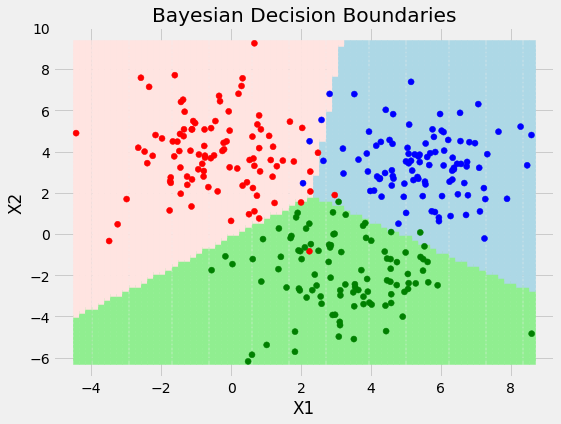

In [3]:
# Plot the data versus the Bayes Decision Boundary.
plt.style.use('fivethirtyeight')

plt.figure(figsize=(8, 6))
plt.scatter(np.transpose(feature_space)[0], np.transpose(feature_space)[1], 
                          color=true_boundary, marker=",")
plt.scatter(np.transpose(X)[0], np.transpose(X)[1], color=point_colors)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Bayesian Decision Boundaries")
plt.show()

When **k** is equal to 1 and to a lesser extent 3, the K-NN models have decision boundaries that are too flexible. There are pockets of the feature space assigned to one class that are enclosed by another, which doesn't quite make sense. The decision spaces of the models with *k* equal to 9 and 15 appear to approximate the true decision boundary much better.

This demonstrates the trade-off with the *k* parameter. Too low and the model will be too flexible; it will overfit. The opposite is also true; too high a *k* and the model is too inflexible, which will be shown in the regression demonstration.

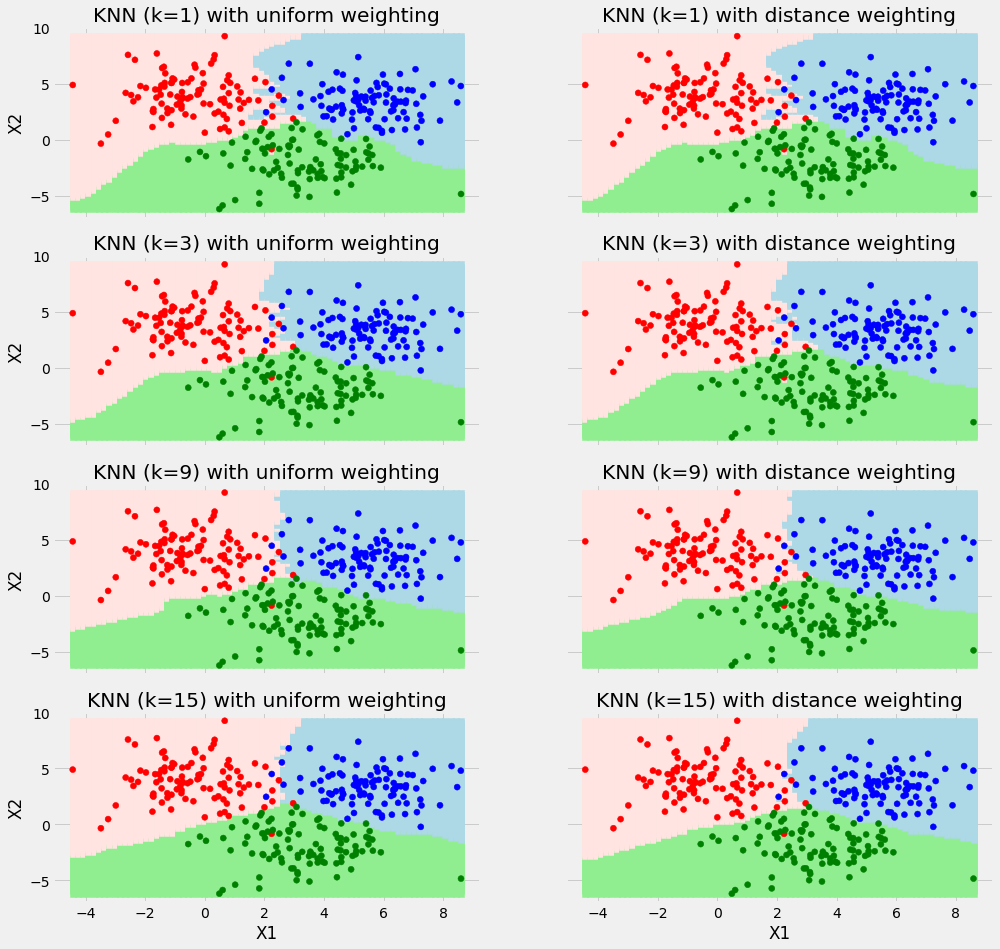

In [4]:
# Create a dictionary to hold the hyperparamters and color codings
# of multiple K-NN Classifiers
decision_space_dict = dict()
# Create a key that will increase by 1 after each model
key_counter = 0
# Create a list of k values to try.
ks_to_try = [1, 3, 9, 15]
# For each k in k values to try...
for k in ks_to_try:
    # For each weight...
    for weights in ["uniform", "distance"]:
        # Instantiate a temporary KNNClassifer object with the k and weight.
        temp_knn = KNNClassifier(k=k, weights=weights)
        # "Fit" it to the data.
        temp_knn.fit(X, y)
        # Get predicted classes of each point in the feature space.
        temp_preds = temp_knn.predict(feature_space)
        # Store a tuple of the hyperparameters and feature space color labels in
        # the dictionary.
        decision_space_dict[key_counter] = [(str(k), weights), 
                                            [background_color_dict[y_i] for y_i in temp_preds]]
        # Increment the key by 1.
        key_counter += 1

nrows, ncols = len(ks_to_try), 2
fig, axs = plt.subplots(nrows, ncols, figsize=(15,15))

key_counter = 0
for i in range(nrows):
    for j in range(ncols):
        axs[i, j].scatter(np.transpose(feature_space)[0], np.transpose(feature_space)[1], 
                          color=decision_space_dict[key_counter][1], marker=",")
        axs[i, j].scatter(np.transpose(X)[0], np.transpose(X)[1], color=point_colors)
        axs[i, j].set_title(f"KNN (k={decision_space_dict[key_counter][0][0]}) with {decision_space_dict[key_counter][0][1]} weighting")
        key_counter += 1

for ax in axs.flat:
    ax.set(xlabel='X1', ylabel='X2')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

### **Regression Demonstration**

To demonstrate K-NN for Regression, I made two scenarios; one where K-NN could perform well and one where it could not. The former scenario involves using K-NN regression on a non-linear function with many training observations. The latter involves using K-NN regression on a linear function with few training observations. K-NN fails in the latter case because there are too few data points to fill out the range of values the feature can take on. With more data, the K-NN regression models with a well selected **k** value could approximate the linear function as well as the non-linear function.

#### **Non-Linear Function with Many Observations**

To demonstrate K-NN regression in this case I simulated 10,000 draws from a standard normal distribution to be the feature used for prediction. I then generated labels from the simulated features using the equation below.

### $y_i = 1 + 2x_i - \frac{1}{4}x_i^2 + \frac{3}{2}x_i^3 + \epsilon_i, \text{ where } \epsilon_i \sim N(0, 4)$

Because we know the true model is a 3-rd degree polynomial with normally distributed errors, we know ordinary least squares regression with a quadratic and cubic term would be our best estimate of the true model. We would probably come to the same conclusion when plotting the data and not knowing the ground truth. Let's just ignore that and focus on K-NN regression.

Next I fit eight K-NN models using **k** values of 1, 5, 10, and 10,000 with both uniform and inverse distance weighting. I plotted the K-NN models versus the true data generating function on top of a scatter plot of the data. As you can see below, at **k** = 1, the model bounces around the true line because it is overfit to the training data. It becomes smoother when **k** is 5, and smoother still when **k** equals 10. When **k** equals the number of observations in the training data, the mean of the labels is predicted. As you can see, the using inverse distance weighting helps the models fit the tails, where the data is sparser, better. K-NN has issues with extrapolating beyond the range of values in the training data, although this is not unique to K-NN. It is generally not good to predict beyond the region in the feature space populated by the training data. 

Overall, the K-NN model looks to perform well for **k** equaling 5 and 10 with inverse distance weighting. Let's look at a case where K-NN performs poorly.  

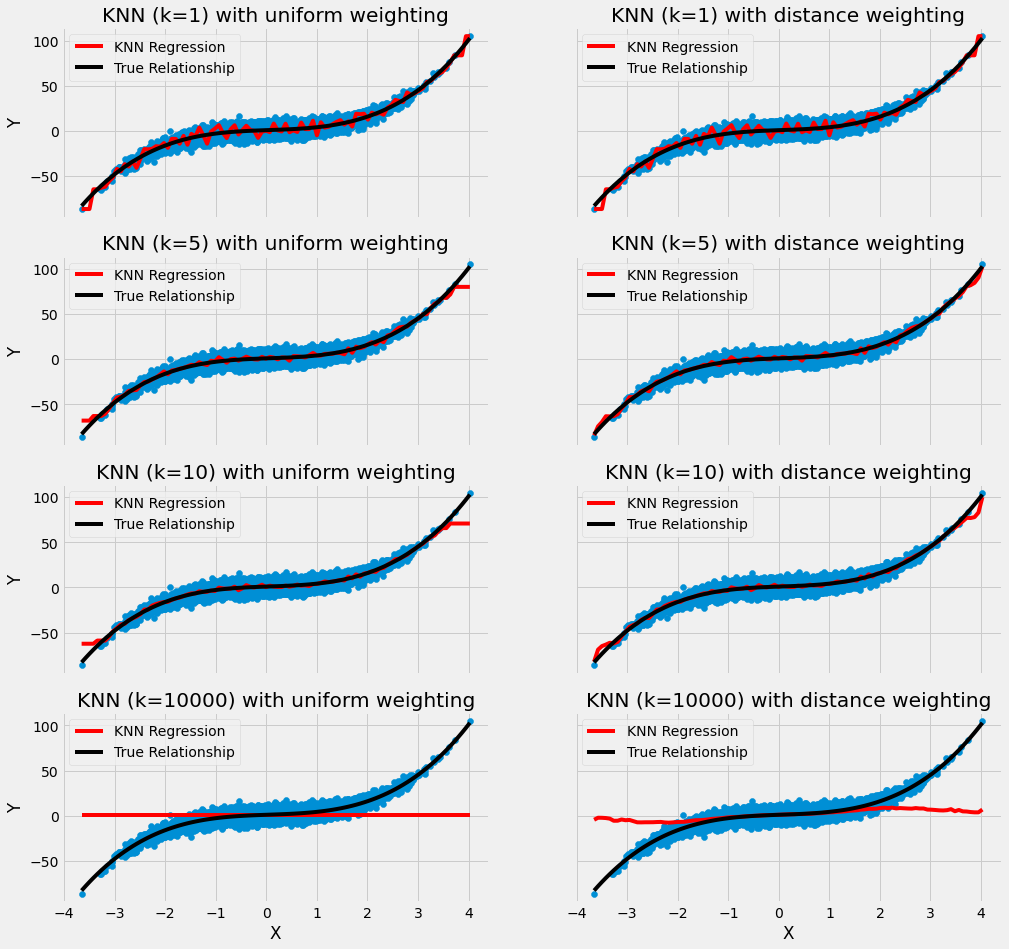

In [5]:
def population_curve(x):
    """This function defines the true relationship
    between x and y and is a cubic function."""
    return  1 + 2*x - 0.25*x**2 + 1.5*x**3

# Set the number of datapoints to generate.
size = 10000
# Generate a sample from a Standard Normal Distribution.
X = np.random.normal(loc=0, scale=1, size=size)
# Generate corresponding y values with some normal random error
# added.
y = population_curve(X) + np.random.normal(loc=0, scale=4, size=size)
# Reshape X to be a column vector.
X = X.reshape(-1,1)

# Create 100 equidistant point between the minimum and maximum value of
x_space = np.linspace(np.min(X), np.max(X), 100).reshape(-1, 1)
true_y = [population_curve(x) for x in x_space.flatten()]

# Create a dictionary to hold the hyperparamters and color codings
# of multiple KNN Regressers.
prediction_dict = dict()
# Create a key that will increase by 1 after each model
key_counter = 0
# Create a list of k values to try.
ks_to_try = [1, 5, 10, size]
# For each k in k values to try...
for k in ks_to_try:
    # For each weight...
    for weights in ["uniform", "distance"]:
        # Instantiate a temporary KNNClassifer object with the k and weight.
        temp_knn = KNNRegresser(k=k, weights=weights)
        # "Fit" it to the data.
        temp_knn.fit(X, y)
        # Get predicted classes of each point in the feature space.
        temp_preds = temp_knn.predict(x_space, smoothing=0.01)
        # Store a tuple of the hyperparameters and feature space color labels in
        # the dictionary.
        prediction_dict[key_counter] = [(str(k), weights), 
                                        temp_preds]
        # Increment the key by 1.
        key_counter += 1

nrows, ncols = len(ks_to_try), 2


fig, axs = plt.subplots(nrows, ncols, figsize=(15,15))

key_counter = 0
for i in range(nrows):
    for j in range(ncols):
        axs[i, j].scatter(X, y)
        axs[i, j].plot(x_space, prediction_dict[key_counter][1], 
                       color="red", label="KNN Regression")
        axs[i, j].plot(x_space, true_y, 
                       color="black", label="True Relationship")
        axs[i, j].set_title(f"KNN (k={prediction_dict[key_counter][0][0]}) with {prediction_dict[key_counter][0][1]} weighting")
        axs[i, j].legend()
        key_counter += 1

for ax in axs.flat:
    ax.set(xlabel='X', ylabel='Y')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

#### **Linear Function with Few Observations**

To create a case where K-NN regression would perform poorly, I drew only 100 values from a standard normal to be the predictor. The data generating process is below:

### $y_i = 1 + 2x_i + \epsilon_i, \text{ where } \epsilon \sim \text{N}(0, 1)$

As you can see, the K-NN model is overfit for all the values of **k** tried, except for when **k** equals the number of observations with uniform weighting, where it is only predicting the average of the training labels. Even though the data generating process is simple, K-NN cannot approximate it well due to the number of training samples.

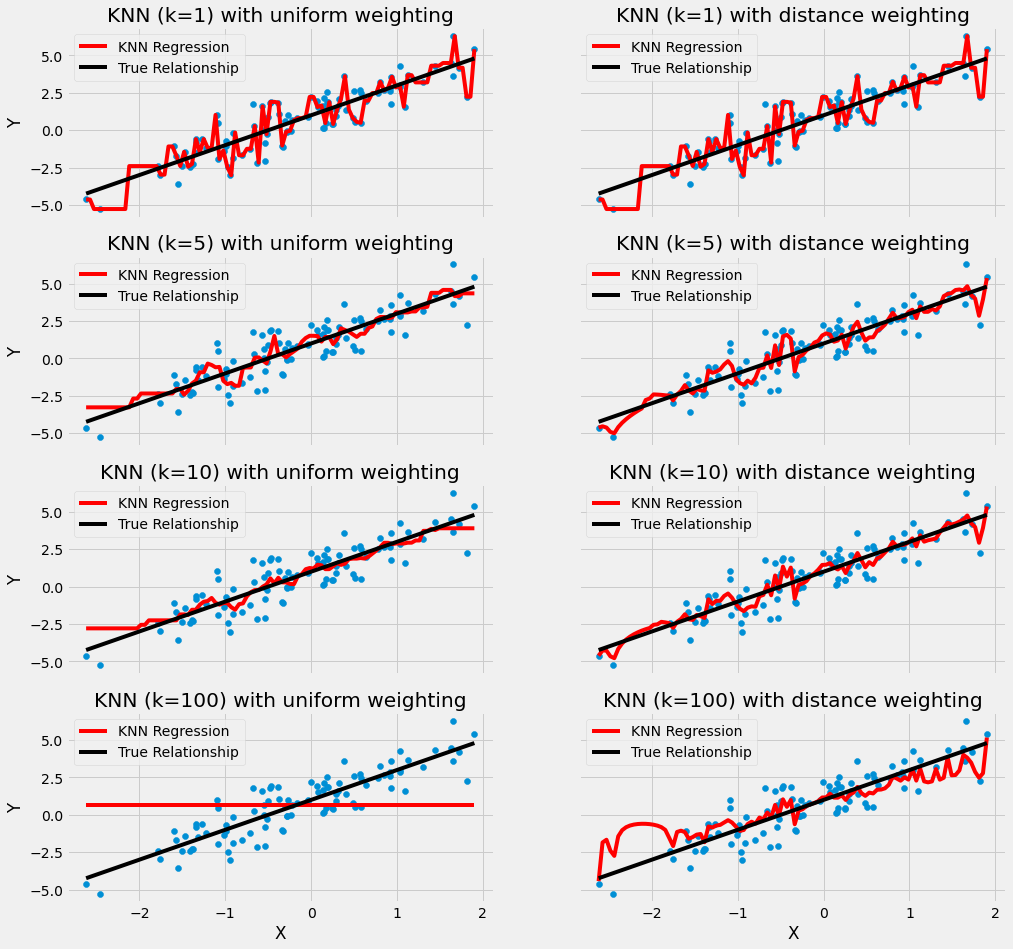

In [6]:
def population_curve(x):
    """This function defines the true relationship
    between x and y and is a cubic function."""
    return  1 + 2*x

# Set the number of datapoints to generate.
size = 100
# Generate a sample from a Standard Normal Distribution.
X = np.random.normal(loc=0, scale=1, size=size)
# Generate corresponding y values with some normal random error
# added.
y = population_curve(X) + np.random.normal(loc=0, scale=1, size=size)
# Reshape X to be a column vector.
X = X.reshape(-1,1)

# Create 100 equidistant point between the minimum and maximum value of
x_space = np.linspace(np.min(X), np.max(X), 100).reshape(-1, 1)
true_y = [population_curve(x) for x in x_space.flatten()]

# Create a dictionary to hold the hyperparamters and color codings
# of multiple KNN Regressers.
prediction_dict = dict()
# Create a key that will increase by 1 after each model
key_counter = 0
# Create a list of k values to try.
ks_to_try = [1, 5, 10, size]
# For each k in k values to try...
for k in ks_to_try:
    # For each weight...
    for weights in ["uniform", "distance"]:
        # Instantiate a temporary KNNClassifer object with the k and weight.
        temp_knn = KNNRegresser(k=k, weights=weights)
        # "Fit" it to the data.
        temp_knn.fit(X, y)
        # Get predicted classes of each point in the feature space.
        temp_preds = temp_knn.predict(x_space, smoothing=0.001)
        # Store a tuple of the hyperparameters and feature space color labels in
        # the dictionary.
        prediction_dict[key_counter] = [(str(k), weights), 
                                        temp_preds]
        # Increment the key by 1.
        key_counter += 1

nrows, ncols = len(ks_to_try), 2
fig, axs = plt.subplots(nrows, ncols, figsize=(15,15))

key_counter = 0
for i in range(nrows):
    for j in range(ncols):
        axs[i, j].scatter(X, y)
        axs[i, j].plot(x_space, prediction_dict[key_counter][1], 
                       color="red", label="KNN Regression")
        axs[i, j].plot(x_space, true_y, 
                       color="black", label="True Relationship")
        axs[i, j].set_title(f"KNN (k={prediction_dict[key_counter][0][0]}) with {prediction_dict[key_counter][0][1]} weighting")
        axs[i, j].legend()
        key_counter += 1

for ax in axs.flat:
    ax.set(xlabel='X', ylabel='Y')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

I hope you now have a good idea of how K-NN works. Furthermore, I hope I have communicated the benefits and drawback of flexibility when modeling, otherwise known as the bias-variance tradeoff. When you have many samples relative to the number of predictors, flexible models (and K-NN in particular) can help improve predictive accuracy by allowing the model more freedom to fit the data. When there are few data points, you are better off imposing structure on your model.